# Extracting tabular data from scanned images

General strategy:

1. Detect lines and then cells in the table

2. Crop each cell in the table as an individual image

3. Apply OCR to each cell, preserving its coordinates in the original table

4. Infer table structure from the pattern of coordinates

5. Reassemble table from list of text values from OCR and estimated table structure

Current issues:
1. Single-value cells may not be read properly, e.g. a text box with just a "1" in it.
2. Unclear how tables with multiple merged cells will behave w.r.t. OCR extraction

In [79]:
# Setup
import os
import math
import shutil
import jenkspy
import itertools
import statistics
import logging
import numpy as np
import pandas as pd

import cv2
import pytesseract
from PIL import Image, ImageOps
from IPython import display

# Display options 
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1

In [80]:
# Key paths 
IMG_PATH = "page1_good.jpg"
DATA_PATH = "01_data/"
OUTPUT_PATH = "02_output/"

# Reset before each run 
def clear_contents(dir_path):
    '''
    Deletes the contents of the given filepath. Useful for testing runs.
    '''
    filelist = os.listdir(dir_path)
    if filelist:
        for f in filelist:
            if os.path.isdir(os.path.join(dir_path, f)):
                shutil.rmtree(os.path.join(dir_path, f))
            else:
                os.remove(os.path.join(dir_path, f))

    return None

clear_contents(OUTPUT_PATH)

## 1. Detecting table cells

### 1.1 Load image

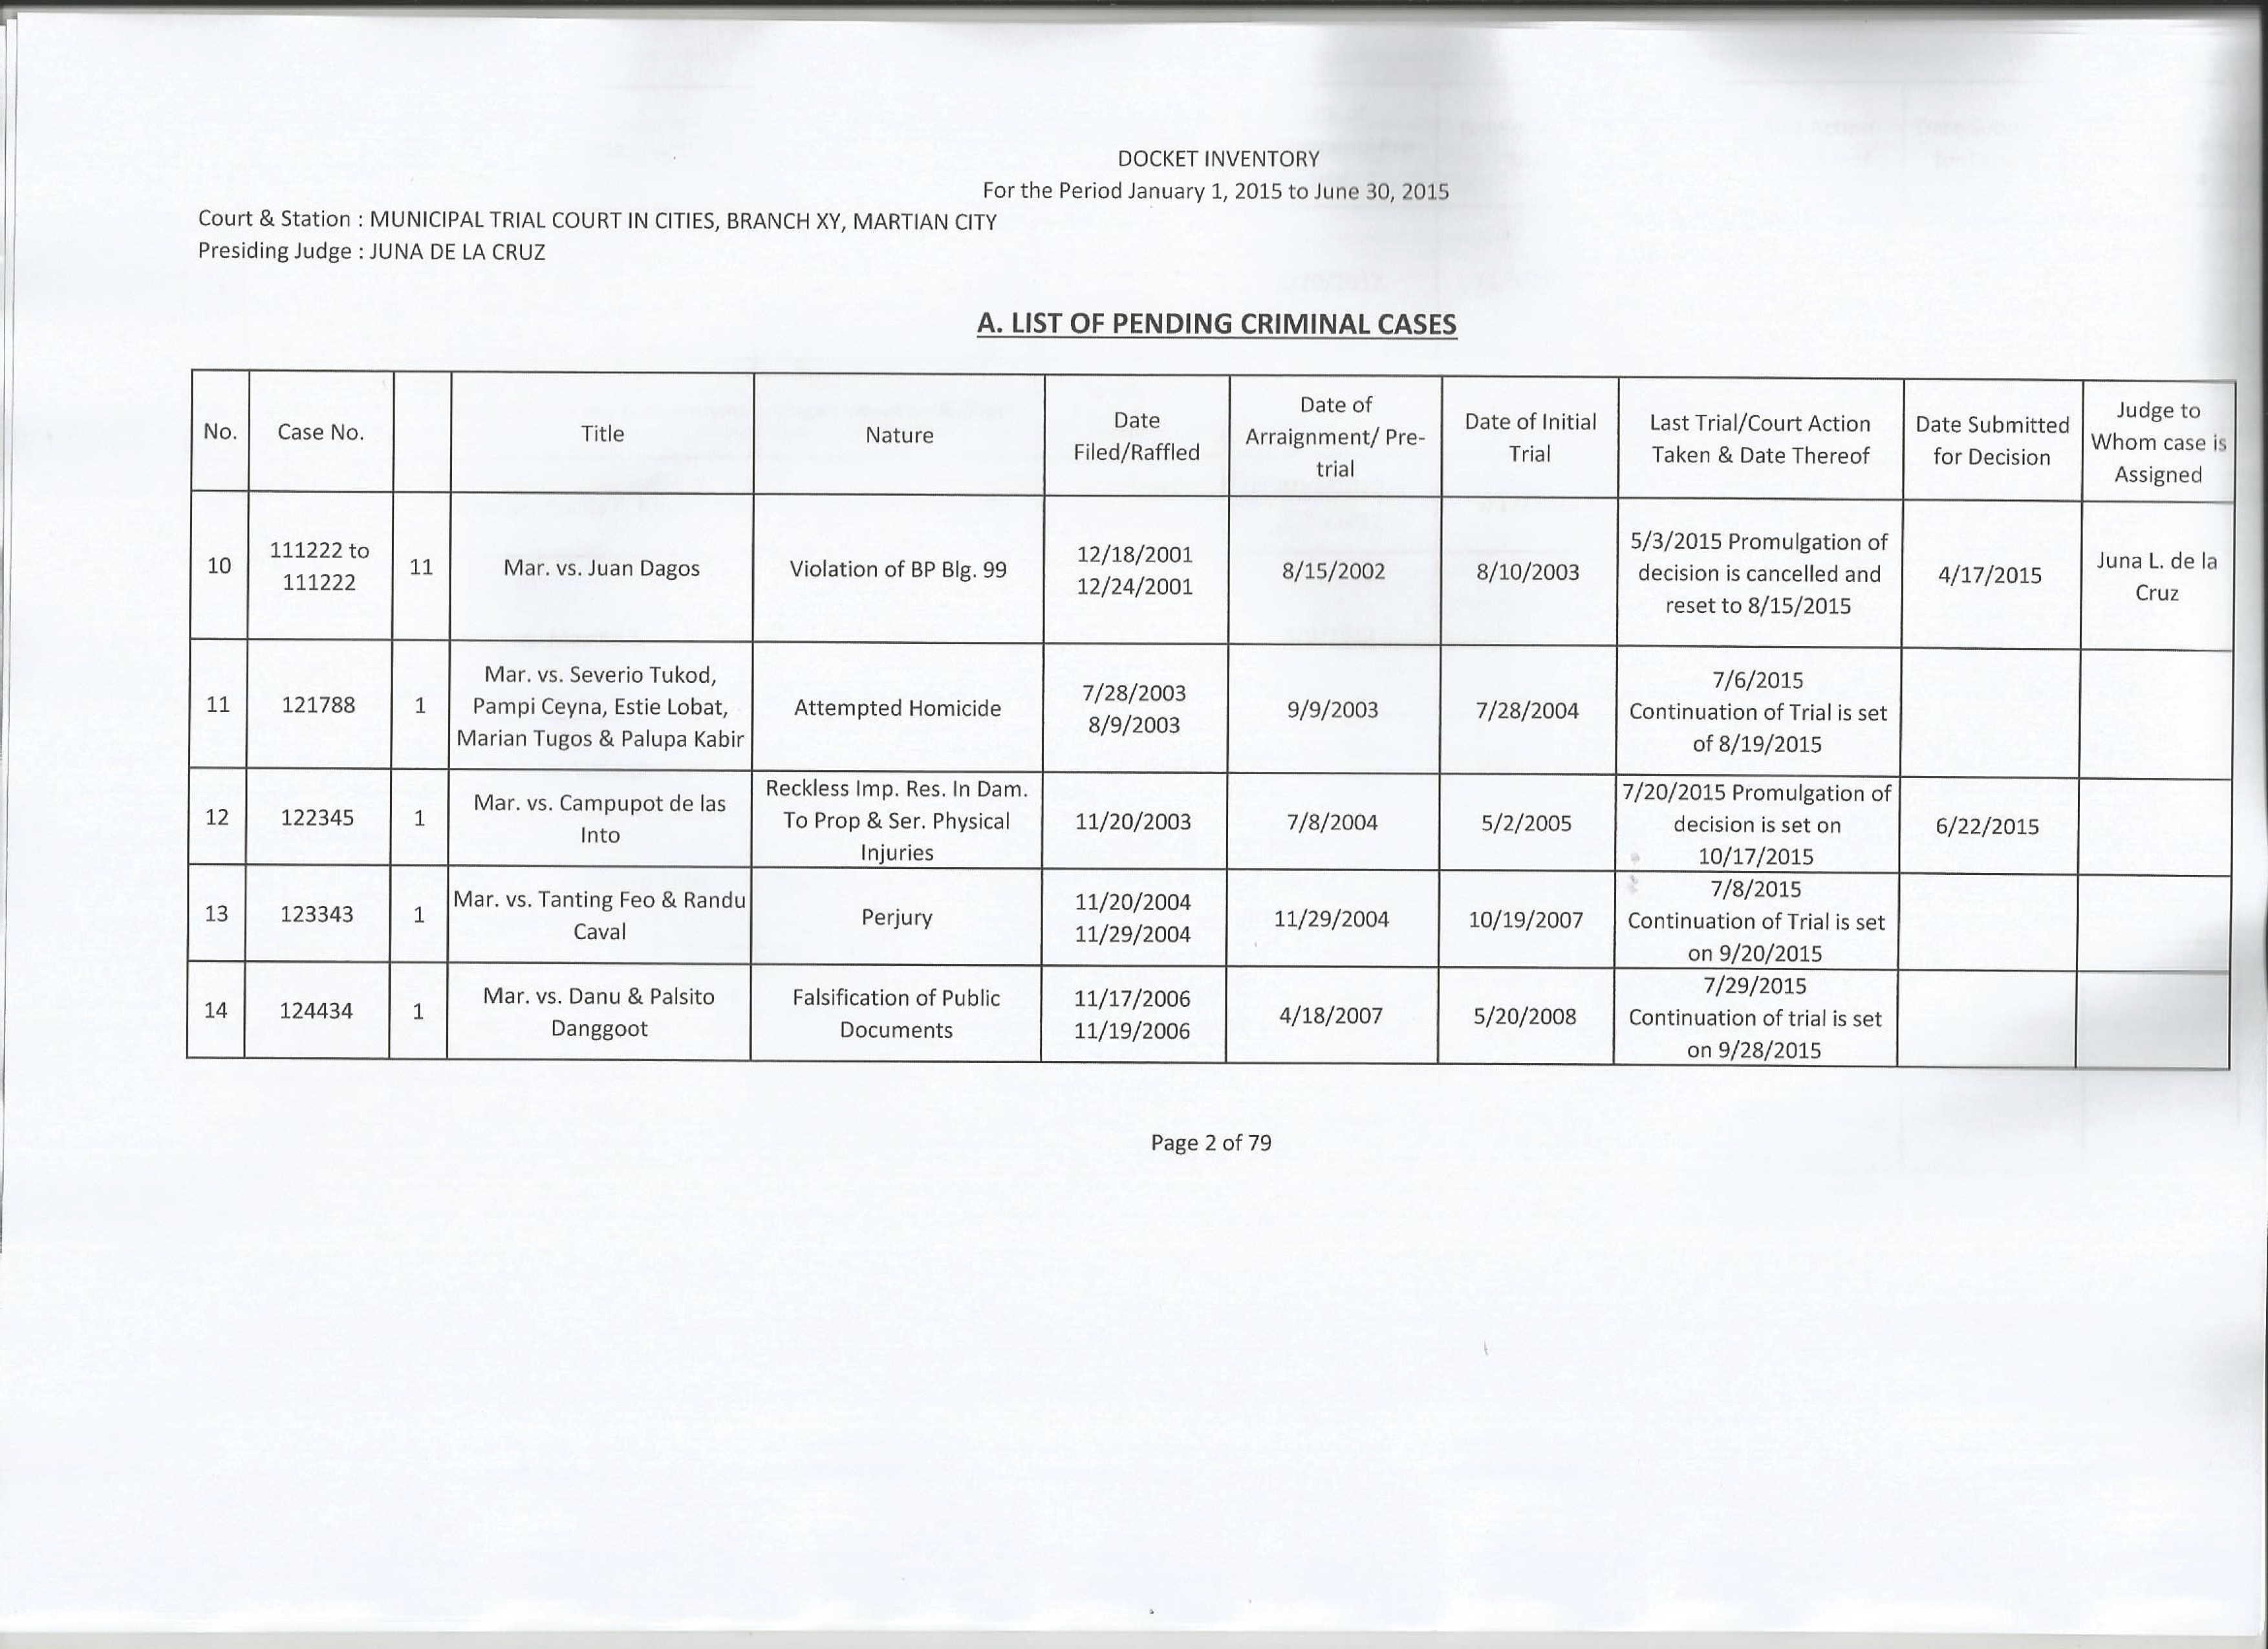

In [81]:
# Read the image
img_original = cv2.imread(DATA_PATH + IMG_PATH, 1)
img = cv2.cvtColor(img_original, cv2.COLOR_RGB2GRAY)

# Image that was input
display.Image(DATA_PATH + IMG_PATH)

### 1.2 Preprocess and deskew image

Rotation detected: -89.67425918579102


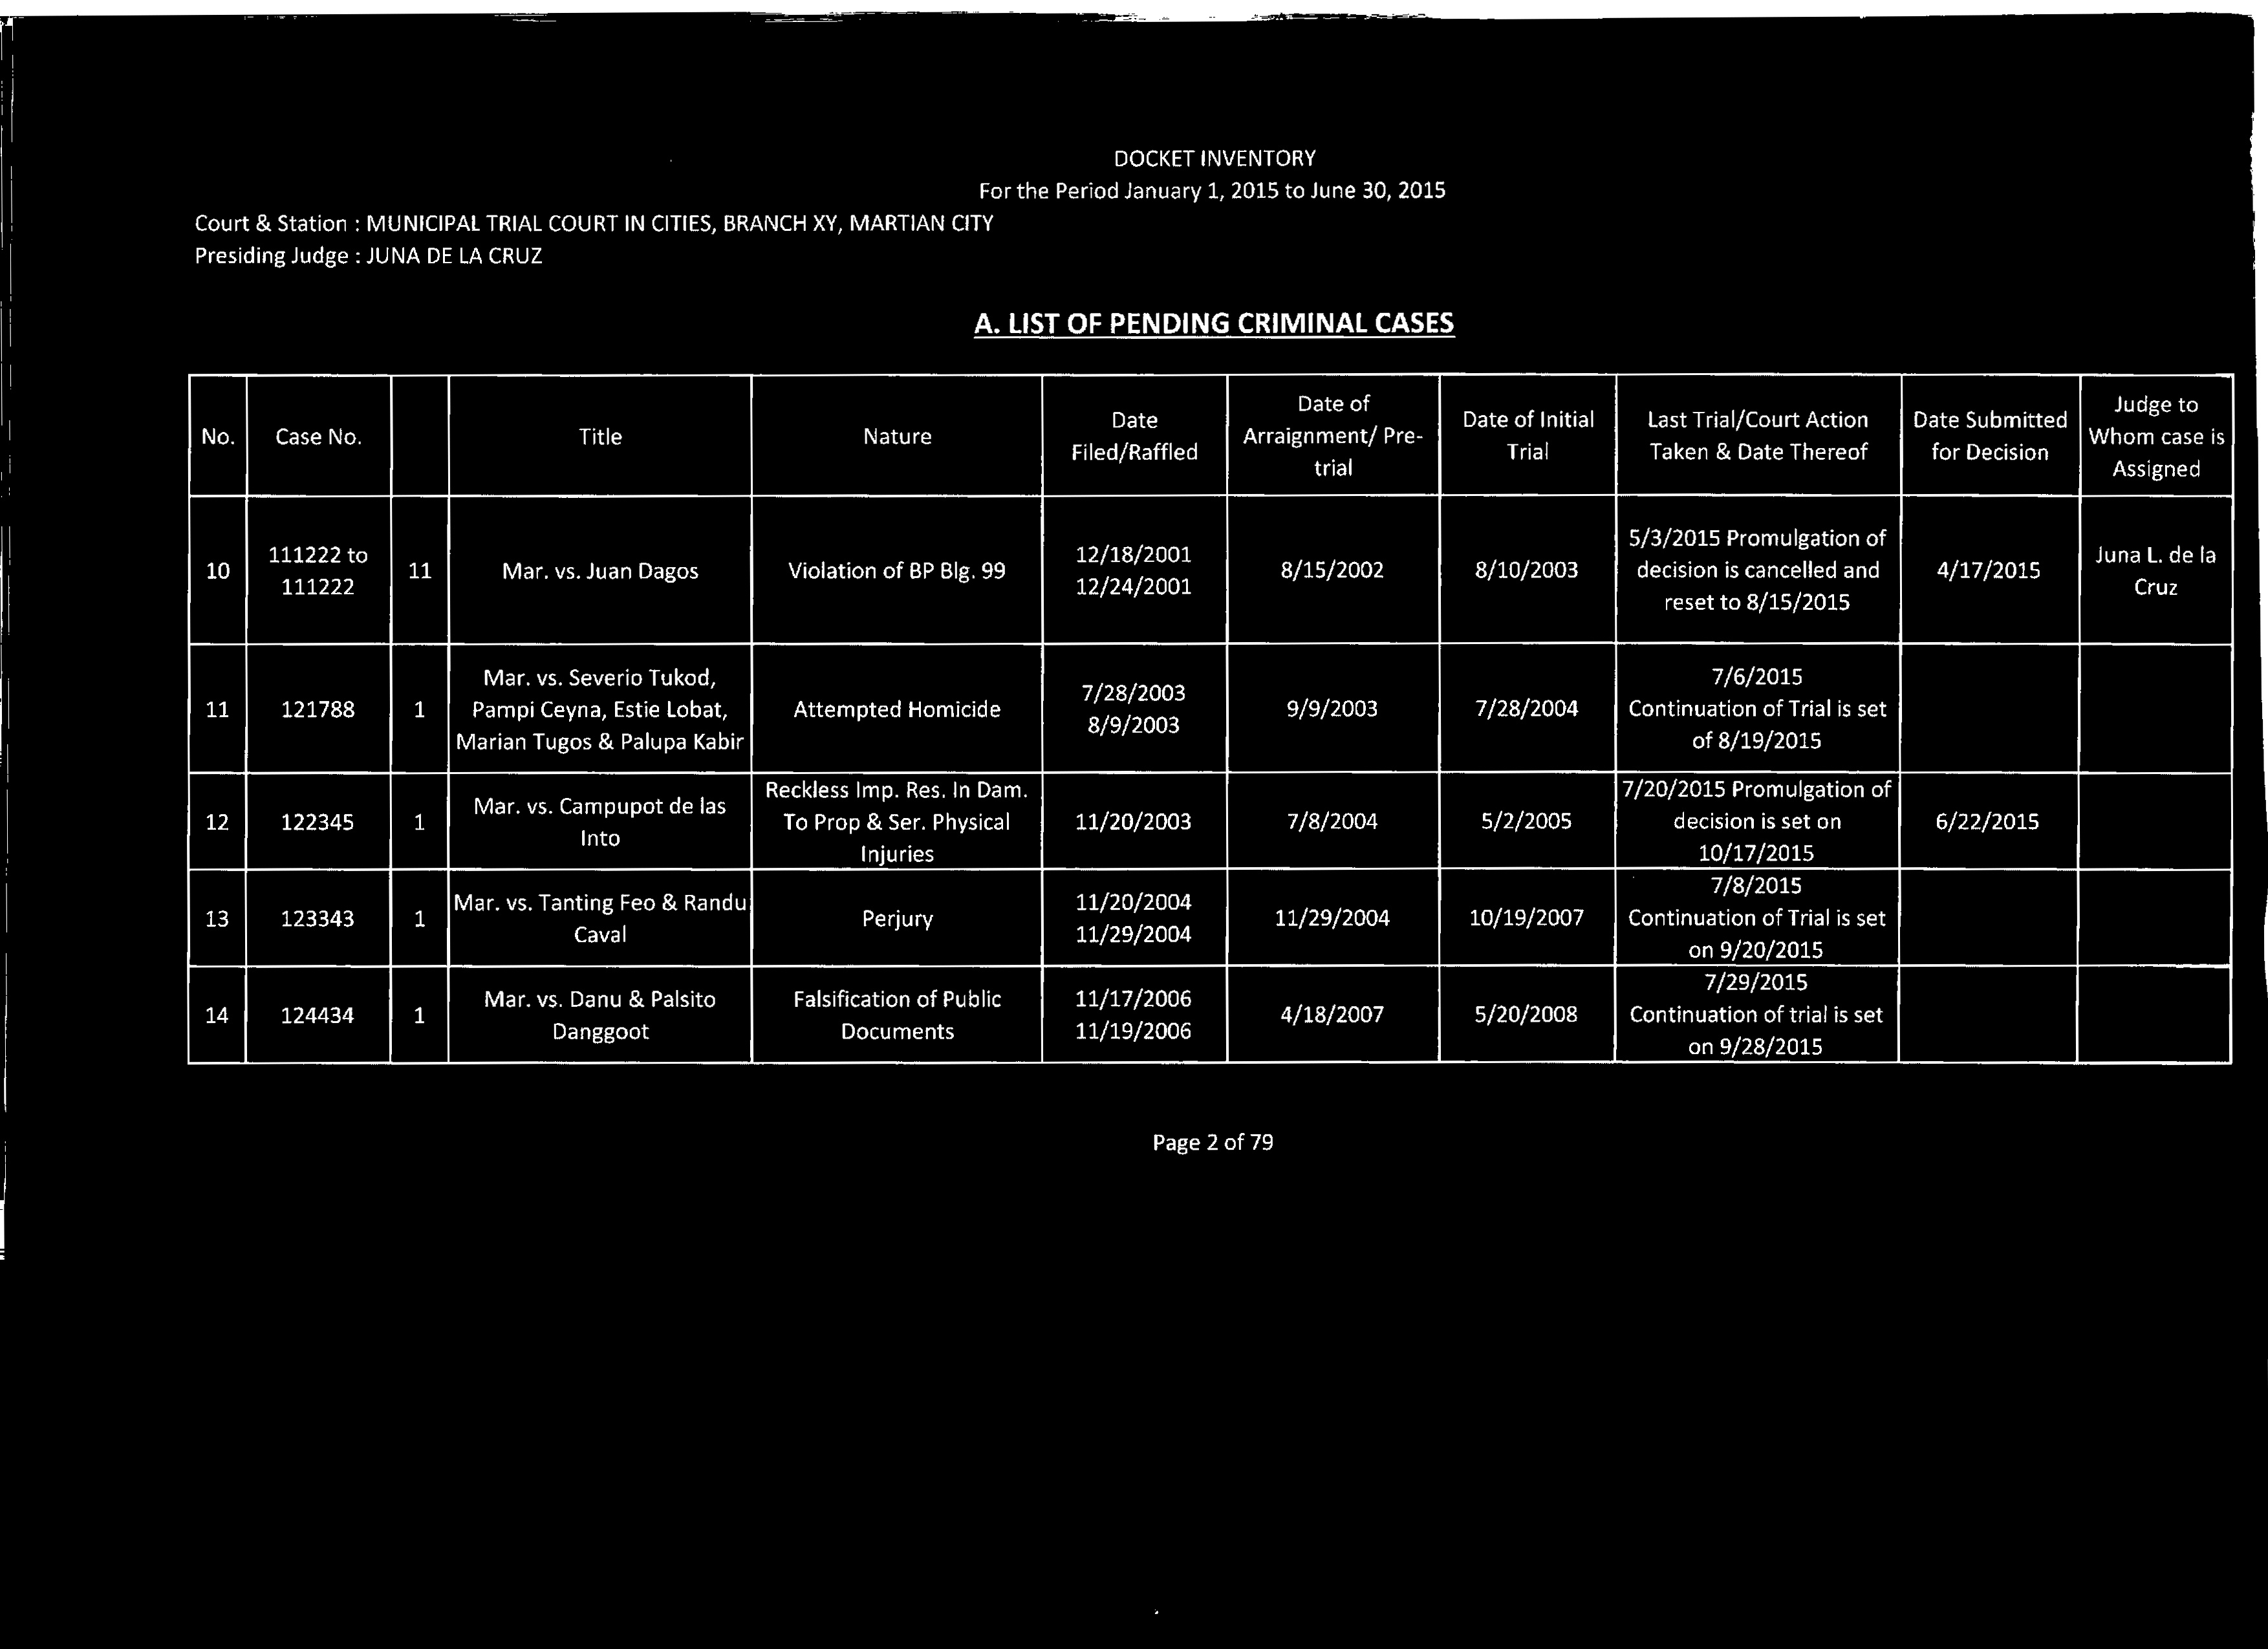

In [82]:
# Thresholding the image
(thresh, img_bin) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Invert the image
img_bin = 255 - img_bin

# Deskew the image
img_rot = cv2.dilate(img_bin, np.ones((1,3)), iterations=10)
img_rot = cv2.erode(img_rot, np.ones((1,3)), iterations=50)
cnt, _ = cv2.findContours(img_rot, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
angle_list = [x[-1] for x in list(map(cv2.minAreaRect, cnt)) \
    if abs(x[-1]) != 0 and abs(x[-1]) != 90]
angle = statistics.median(angle_list)
print("Rotation detected:", angle)

# Prevent wild rotation by more than 45 degrees
if angle < -45:
    angle += 90
elif angle > 45:
    angle -= 90

# rotate the image to deskew it
(h, w) = img_bin.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
img_bin = cv2.warpAffine(img_bin,
                         M,
                         (w, h),
                         flags=cv2.INTER_CUBIC,
                         borderMode=cv2.BORDER_REPLICATE)


# Display image
cv2.imwrite(OUTPUT_PATH + "01_Image_bin.jpg", img_bin)
display.Image(OUTPUT_PATH +'01_Image_bin.jpg') 

### 1.3 Create vertical and horizontal kernels

In [83]:
# Define kernel length
kernel_length = np.array(img).shape[1] // 160

# Detect vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# Detect horizontal lines
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
# Kernel of 3X3 ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

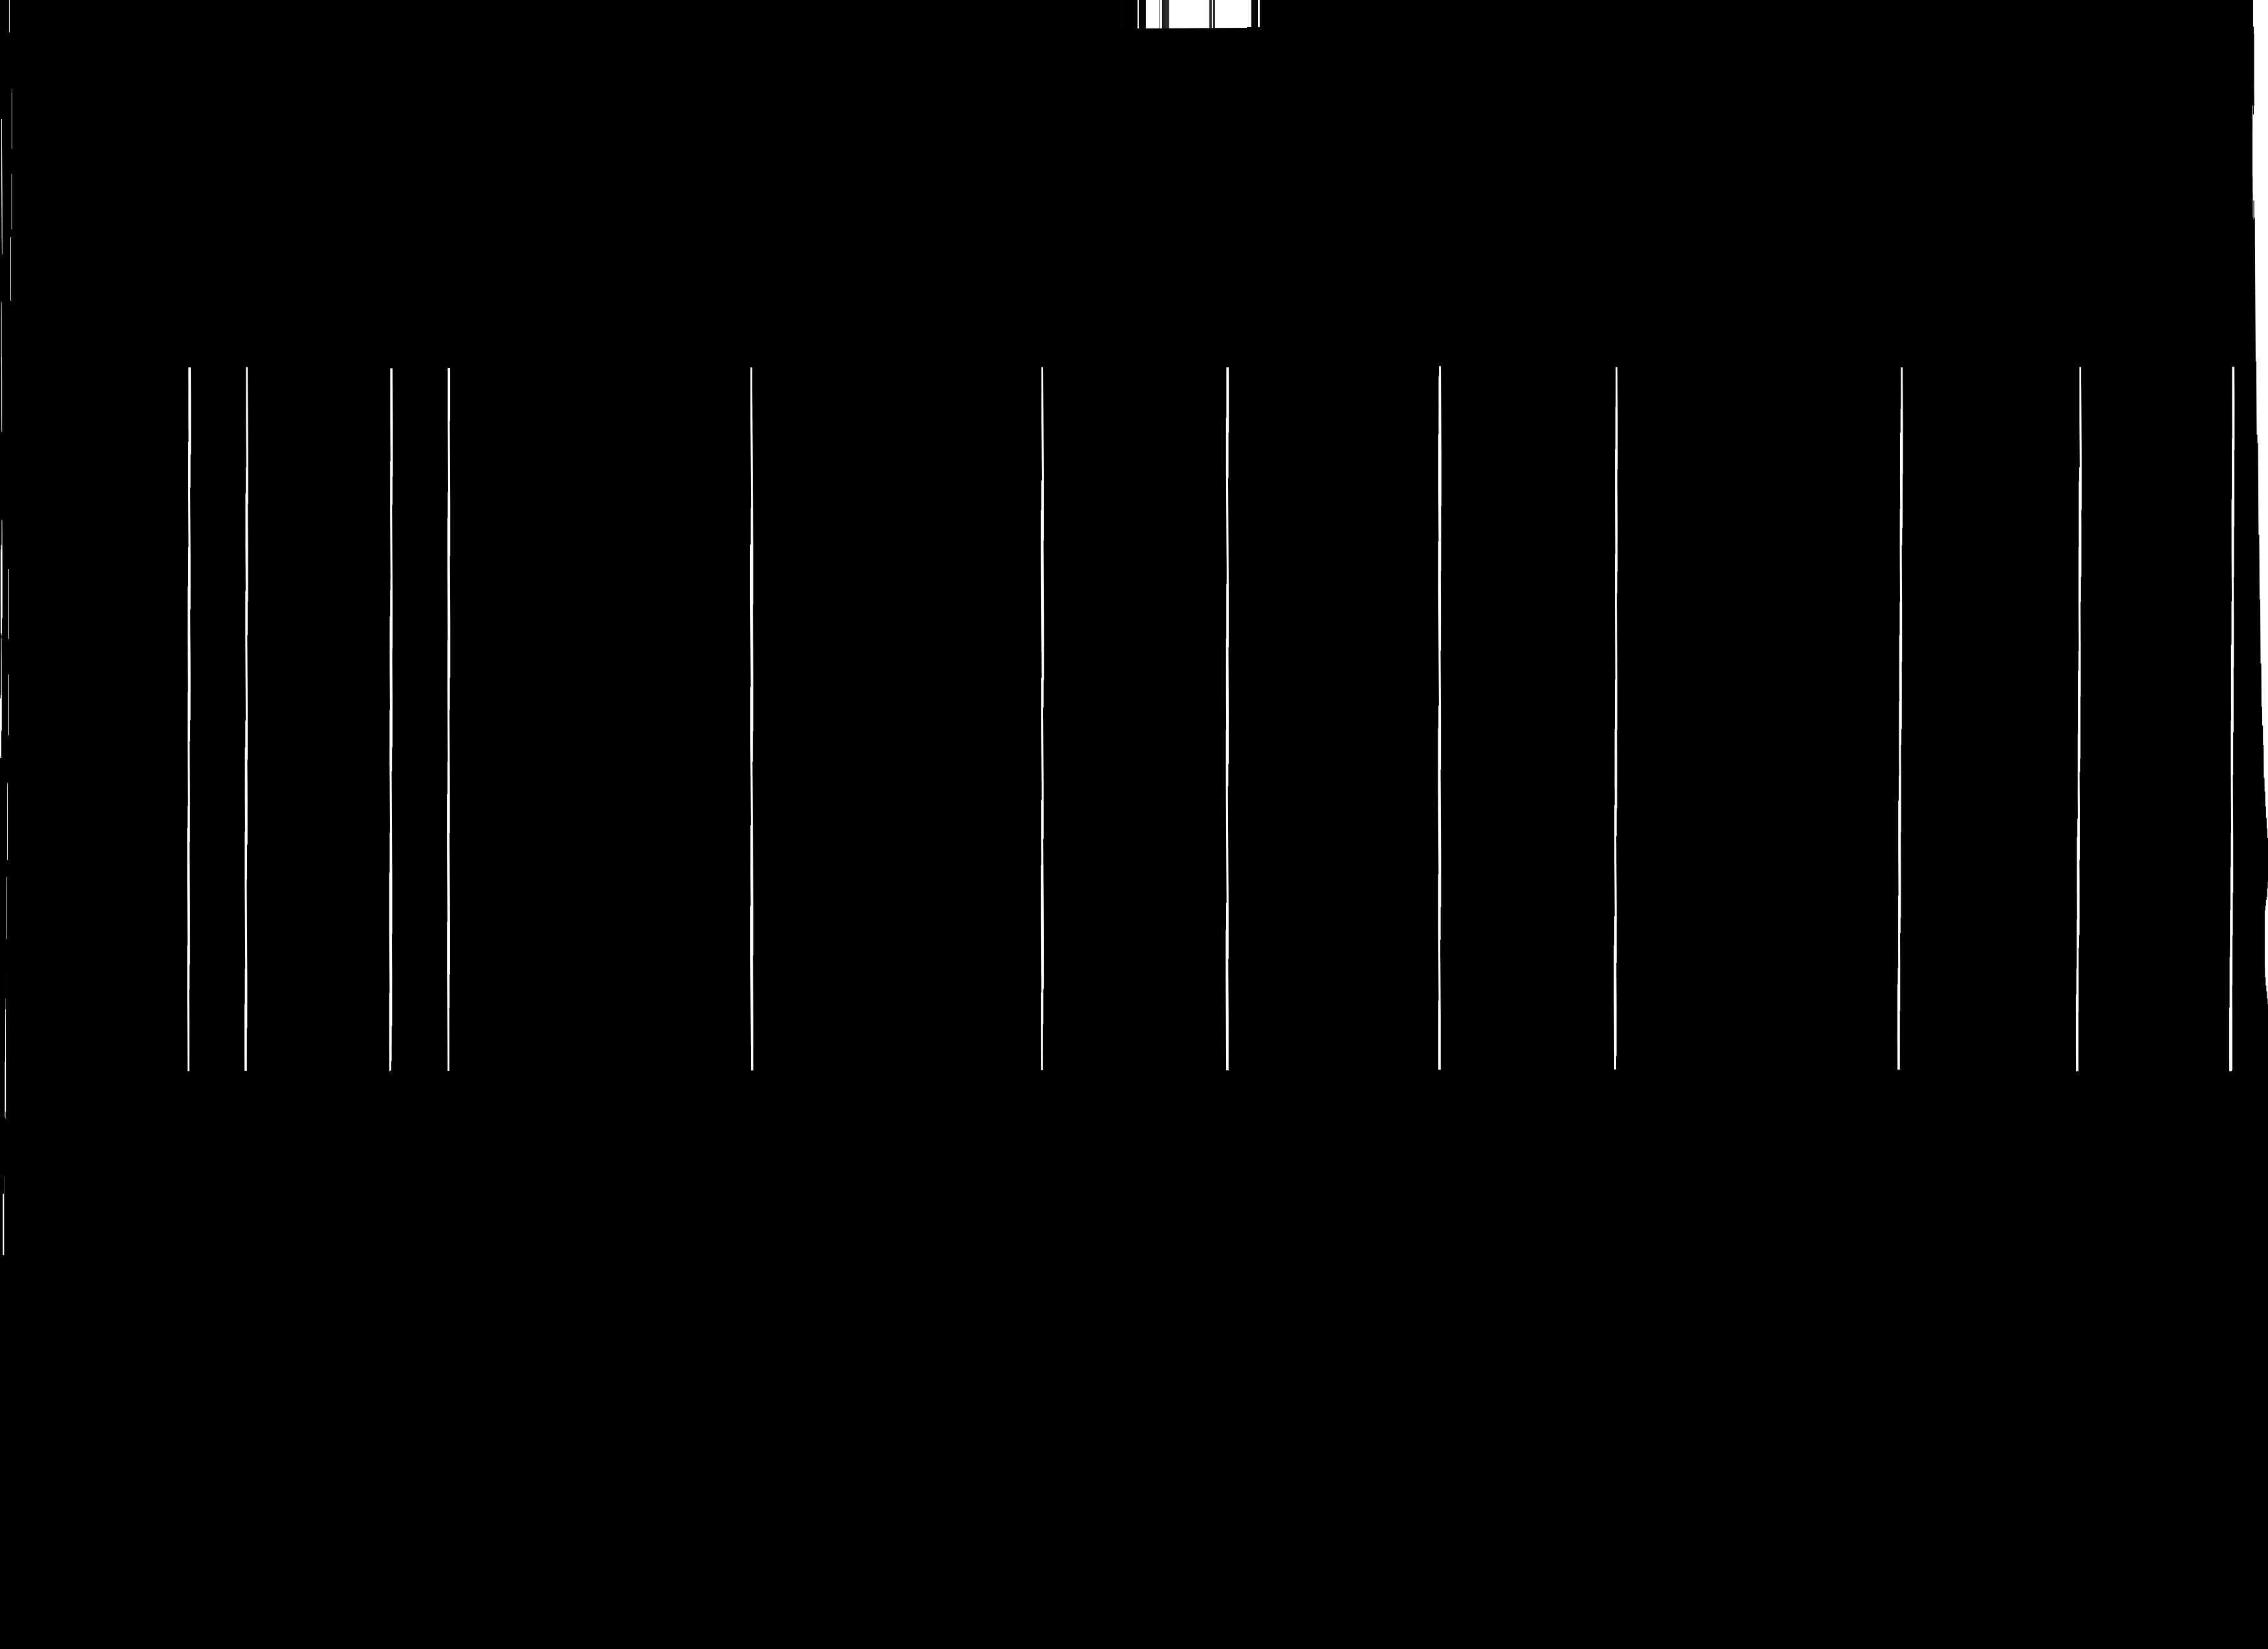

In [84]:
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, vertical_kernel, iterations=3)
v_img = cv2.dilate(img_temp1, vertical_kernel, iterations=4)

# Write result to check
cv2.imwrite(OUTPUT_PATH + "03_vertical_lines.jpg", v_img)
display.Image(OUTPUT_PATH + '03_vertical_lines.jpg') 

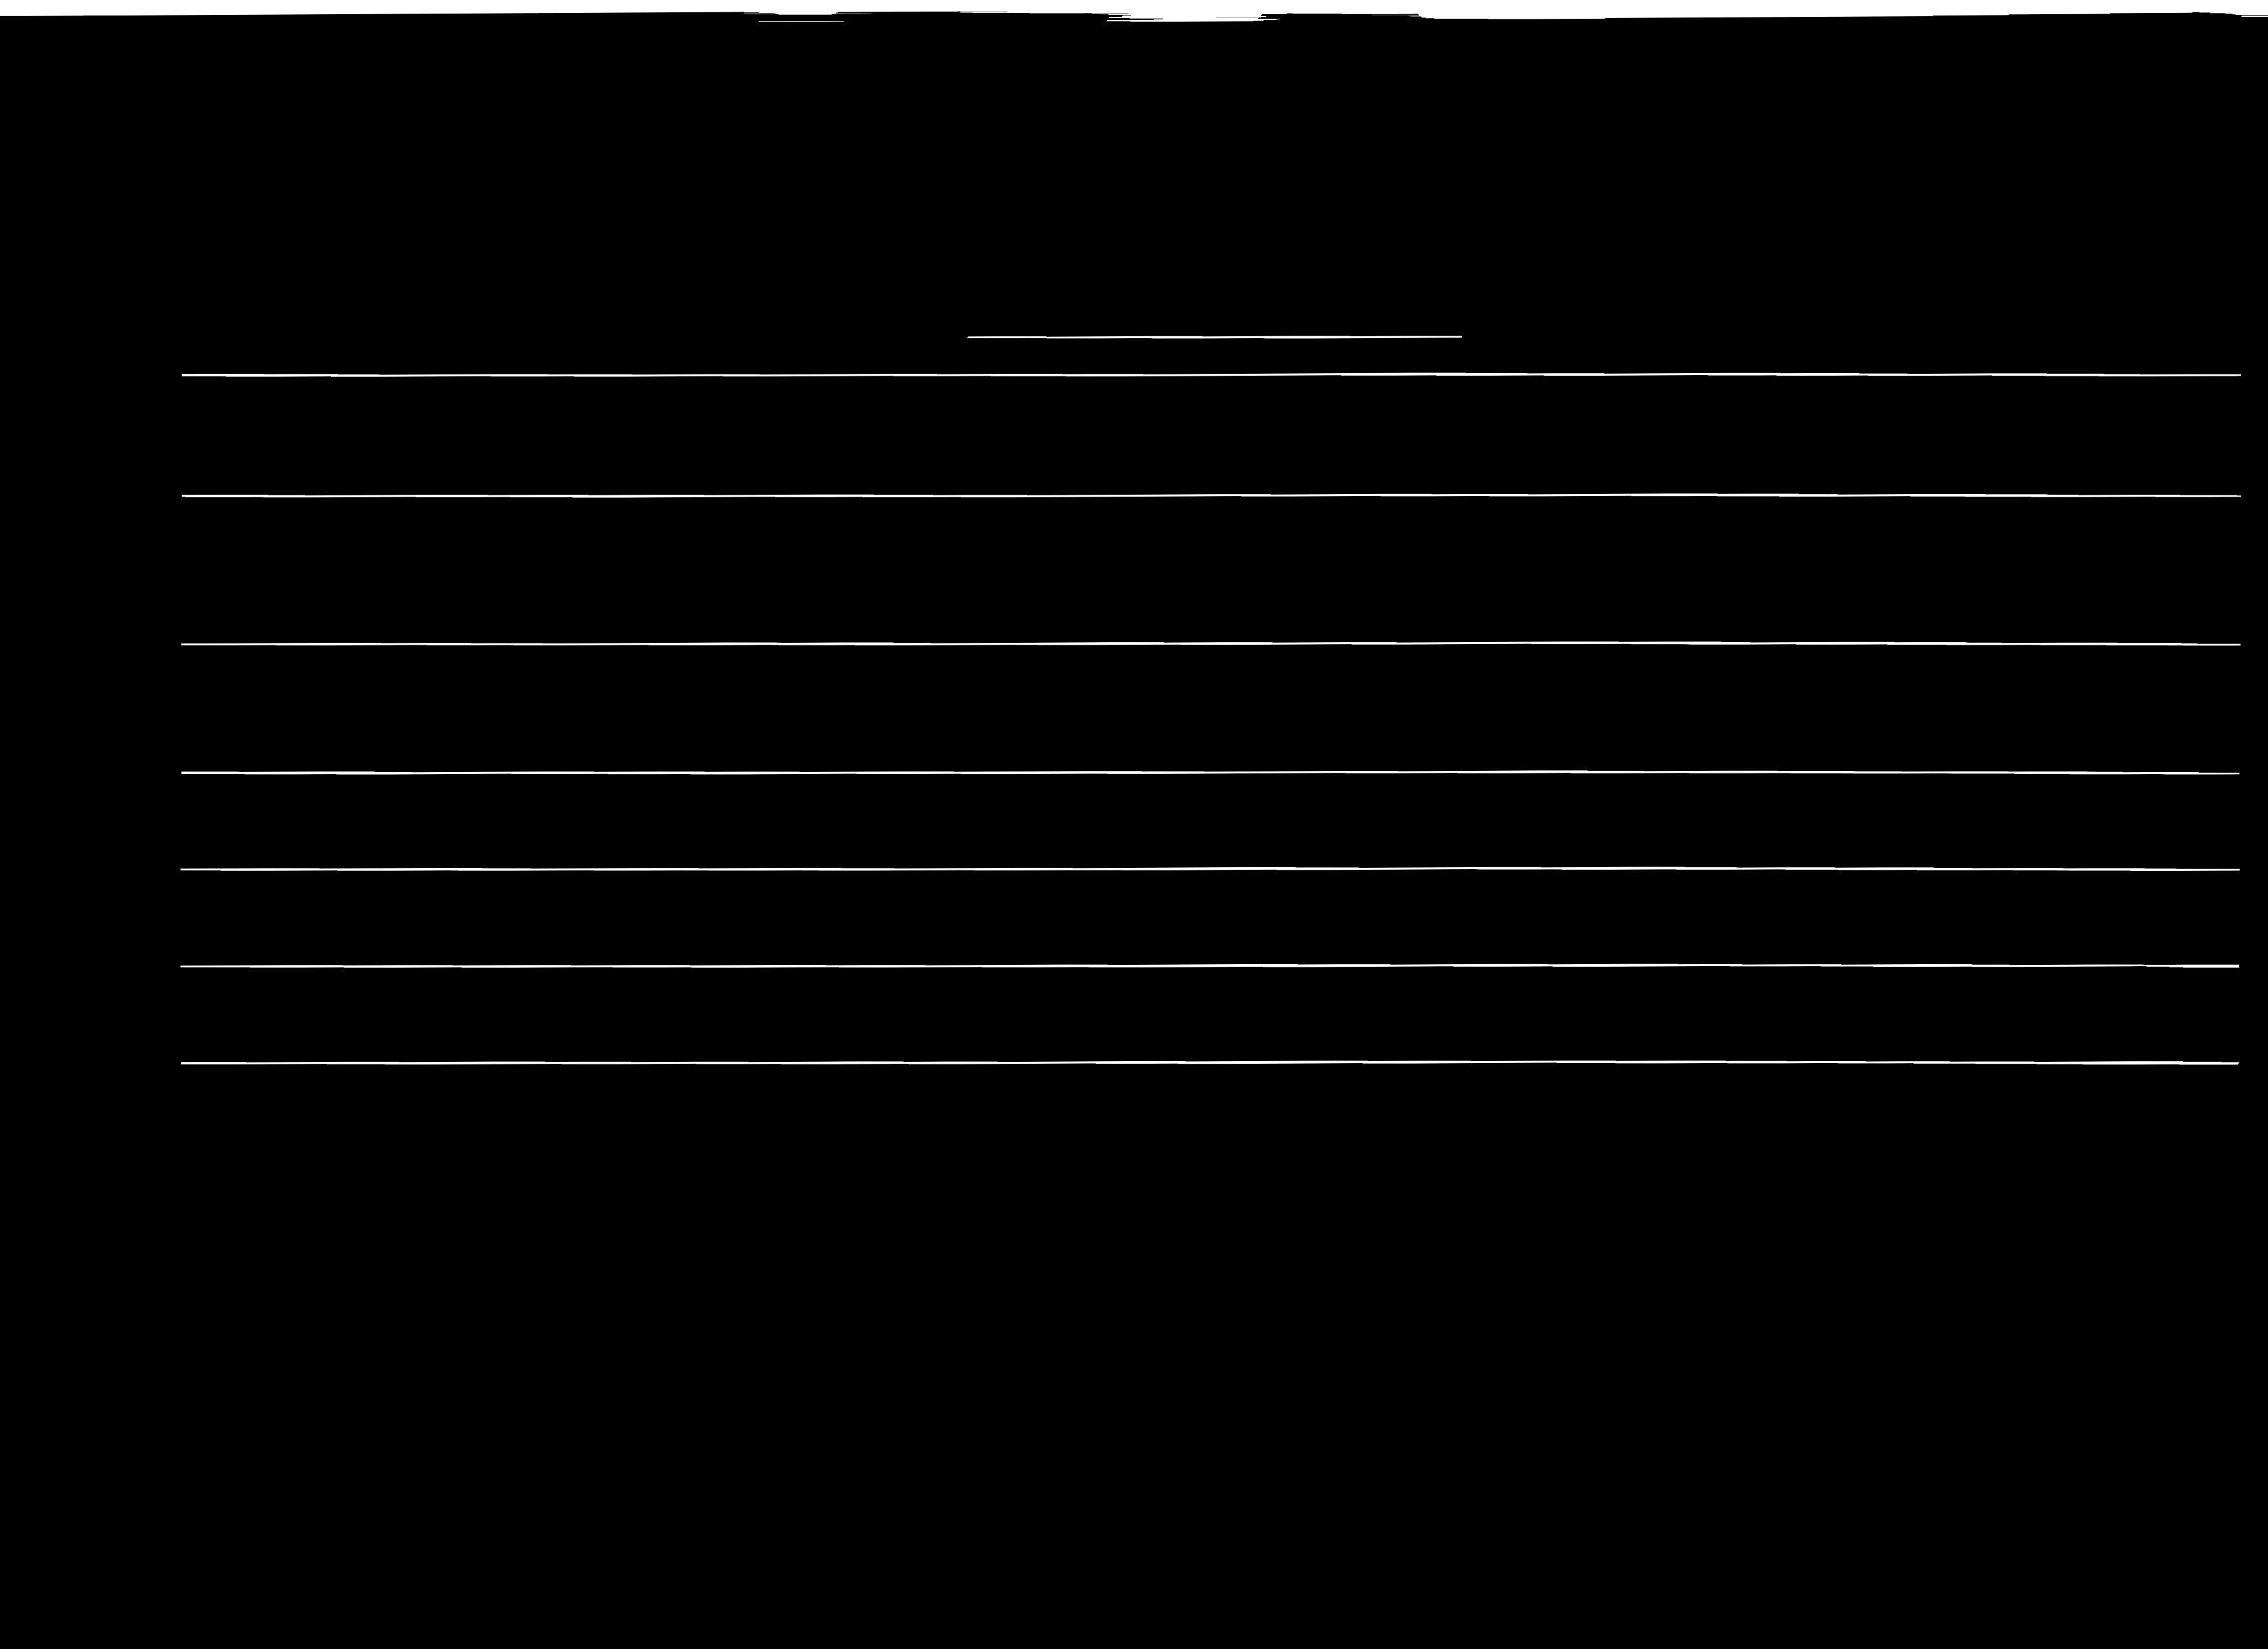

In [85]:
# Detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
h_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)

# Write result to check
cv2.imwrite(OUTPUT_PATH + "02_horizontal_lines.jpg", h_img)
display.Image(OUTPUT_PATH + '02_horizontal_lines.jpg') 

### 1.4 Combine vertical and horizontal kernels to get table bounds

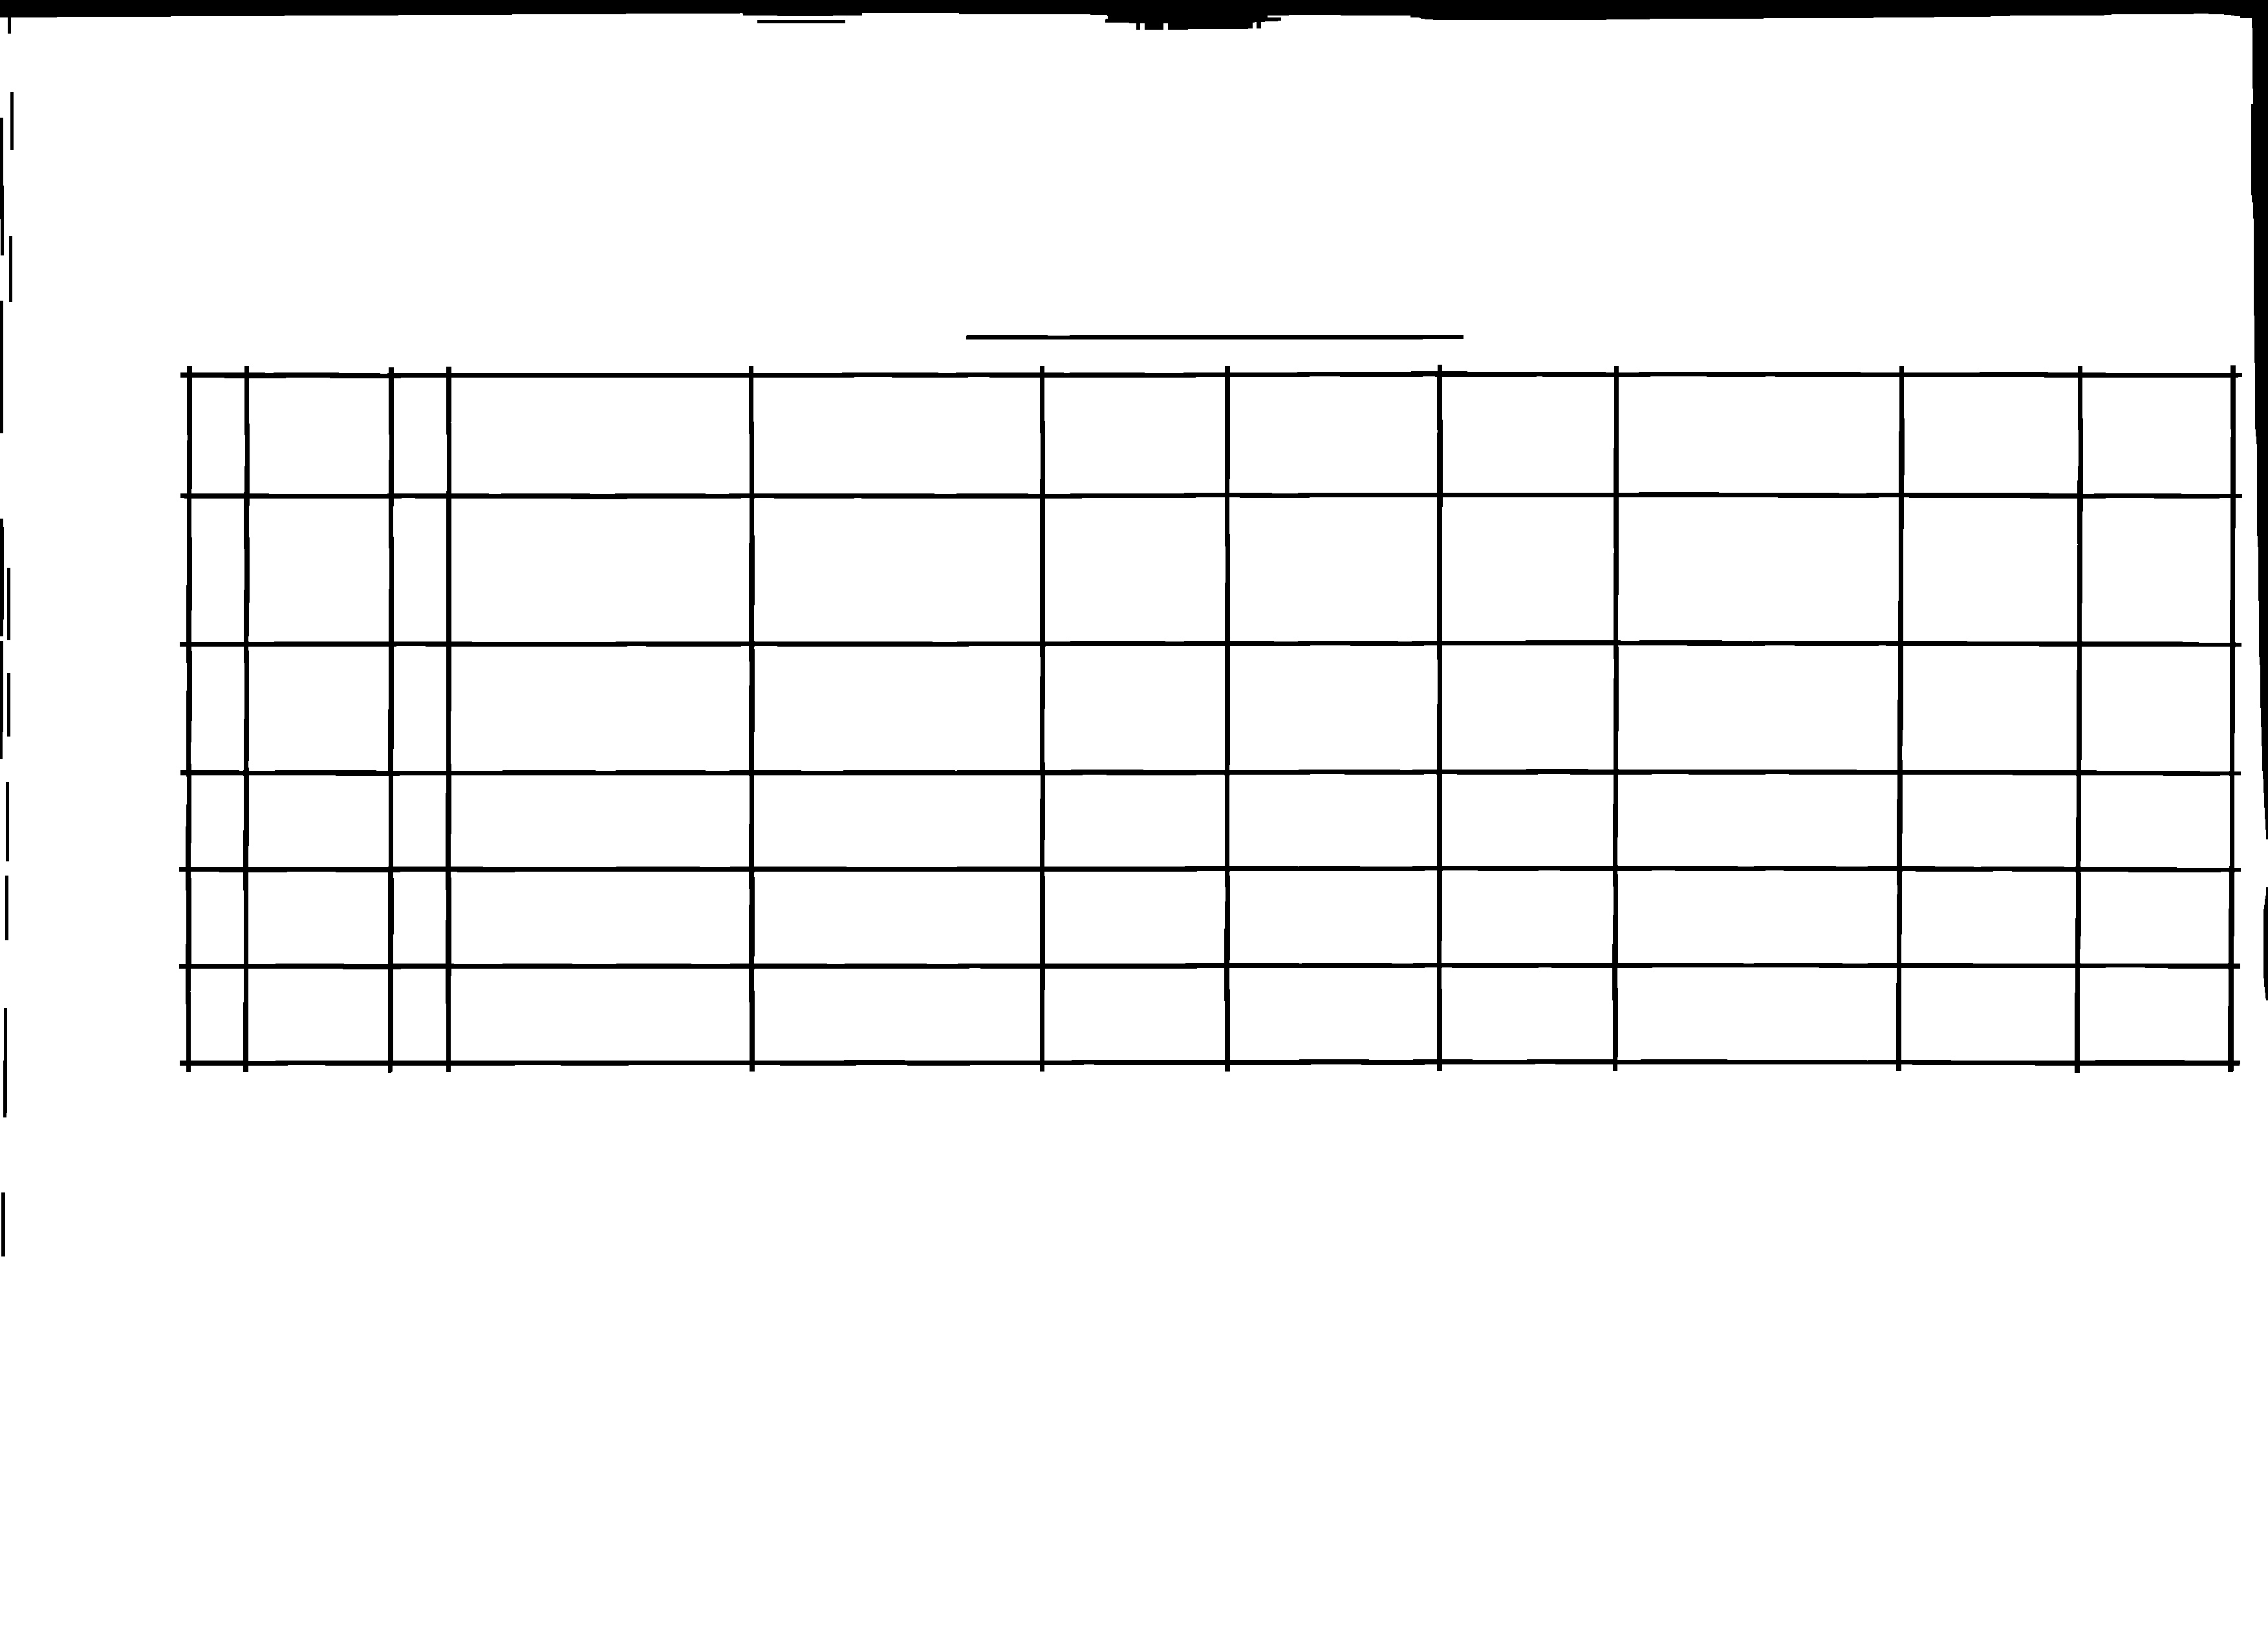

In [86]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha

# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(v_img, alpha, h_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# Write result to check
cv2.imwrite(OUTPUT_PATH + "04_img_final_bin.jpg", img_final_bin)
display.Image(OUTPUT_PATH + "04_img_final_bin.jpg") 

### 1.5 Find contours and filter away cells that are too large

In [87]:
# Find contours for image, which will detect all the boxes
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Filter contours to retain boxes we want
contours_filtered = []
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
    # Only retain contours of cells, not lines or overall table
    if w > 30 and h > 30 and w < (0.5 * img.shape[1]):
        contours_filtered.append(c)

In [88]:
# Verify - there should be 66 cells
len(contours_filtered)

66

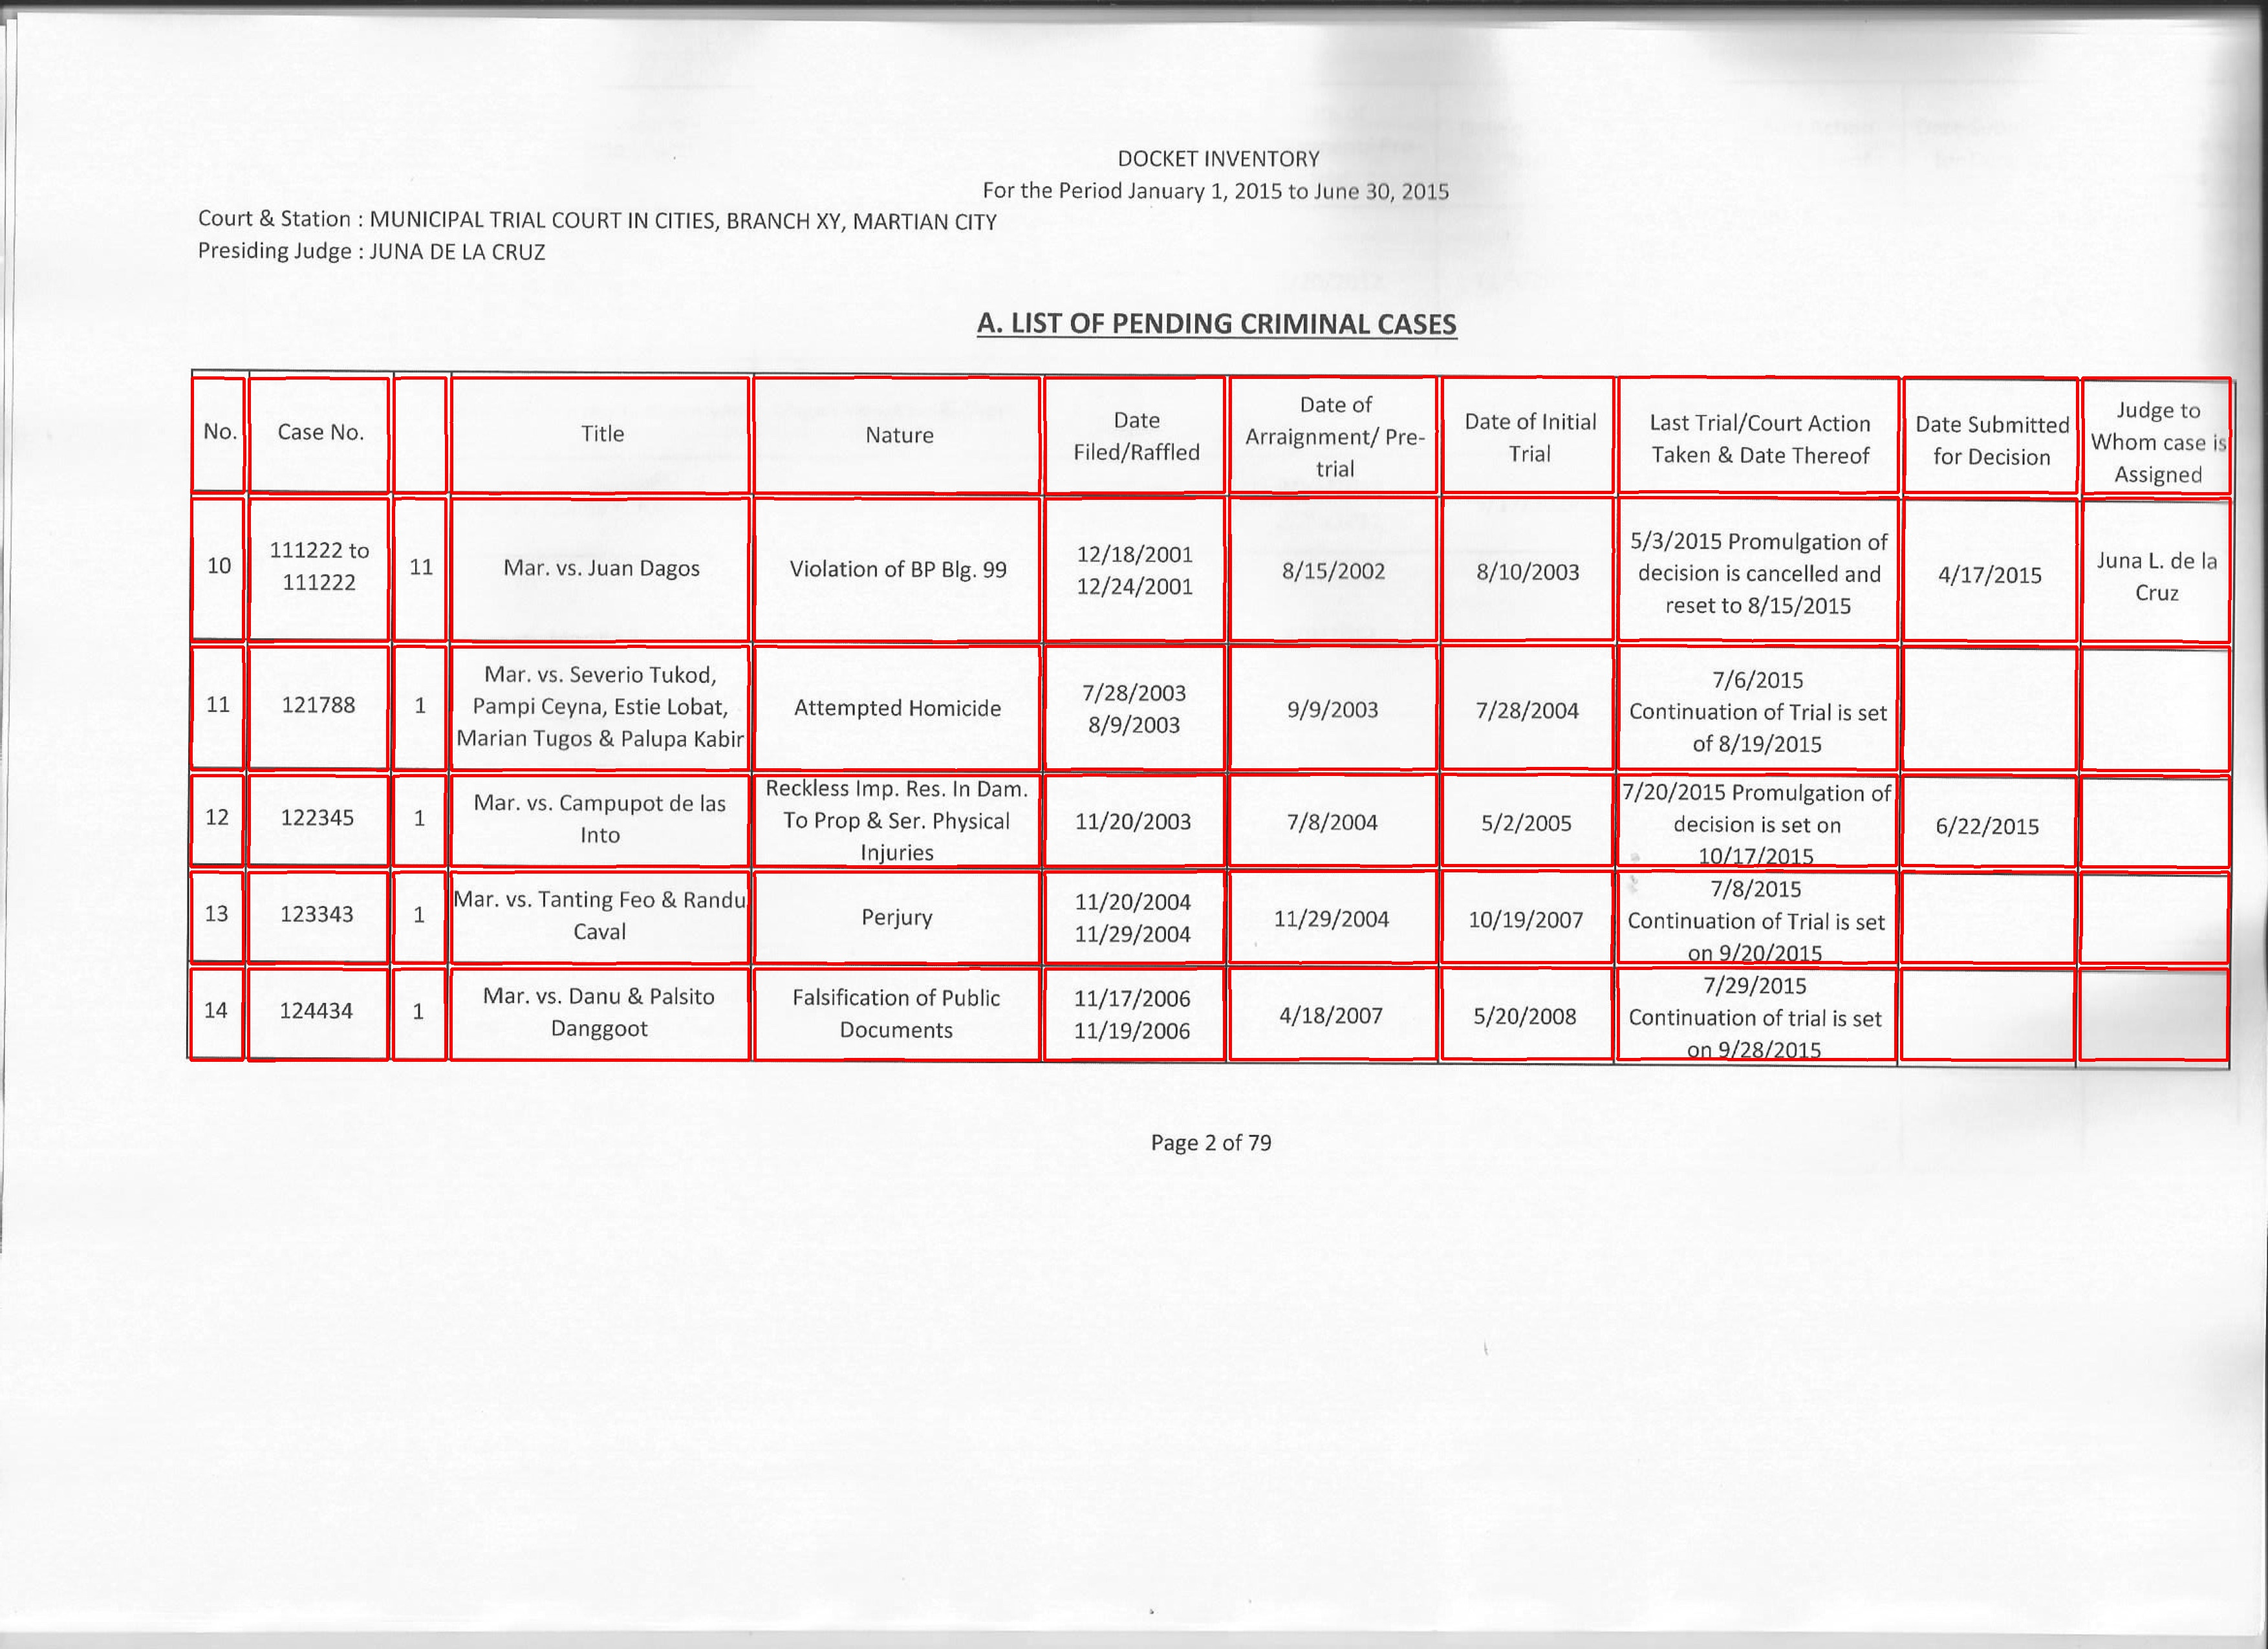

In [89]:
# Show contour results overlaid on original image
img1 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img1, contours_filtered, -1, (0,0,255), 3)

# Save and display
cv2.imwrite(OUTPUT_PATH + "05_img_with_boxes.jpg", img1)
display.Image(OUTPUT_PATH + "05_img_with_boxes.jpg")

## 3. Apply OCR to each table cell

### 3.1 Compile contours into dataframe, extract bounding boxes

In [90]:
# Get dataframe
contour_df = pd.DataFrame(contours_filtered).rename({0: 'contours'}, axis=1)

# Get coordinates of bounding boxes
contour_df['xywh'] = contour_df['contours'].apply(cv2.boundingRect)

contour_df.head()

contours  \
0  [[[698, 1498]], [[698, 1508]], [[697, 1509]], [[697, 1639]], [[1158, 1639]], [[1158, 1550]], [[1157, 1549]], [[1157, 1498]]]              
1  [[[620, 1498]], [[619, 1499]], [[608, 1499]], [[608, 1639]], [[689, 1639]], [[689, 1552]], [[688, 1551]], [[688, 1498]]]                  
2  [[[384, 1498]], [[384, 1640]], [[425, 1640]], [[426, 1639]], [[599, 1639]], [[599, 1499]], [[530, 1499]], [[529, 1498]]]                  
3  [[[295, 1498]], [[295, 1532]], [[294, 1533]], [[295, 1534]], [[295, 1639]], [[375, 1639]], [[375, 1550]], [[376, 1549]], [[376, 1498]]]   
4  [[[2940, 1497]], [[2940, 1638]], [[3016, 1638]], [[3017, 1639]], [[3207, 1639]], [[3207, 1535]], [[3208, 1534]], [[3208, 1497]]]          

                     xywh  
0  (697, 1498, 462, 142)   
1  (608, 1498, 82, 142)    
2  (384, 1498, 216, 143)   
3  (294, 1498, 83, 142)    
4  (2940, 1497, 269, 143)

### 3.2 Read text in image at each bounding box

In [91]:
def read_text_from_coords(img, coords):
    '''
    Takes the image in question, finds the bounding box given by the given coordinates, and returns text in the box.
    '''
    x, y, w, h = coords
    
    # Crop image, then add 20px white border
    img_to_read = img[y:y+h, x:x+w]
    img_to_read = np.pad(img_to_read, pad_width=20, mode='constant', constant_values=0)
    
    # Read text
    text = pytesseract.image_to_string(img_to_read)
    
    return text

contour_df['text'] = contour_df.apply(lambda x: read_text_from_coords(img, x['xywh']), axis=1)

contour_df.head()

contours  \
0  [[[698, 1498]], [[698, 1508]], [[697, 1509]], [[697, 1639]], [[1158, 1639]], [[1158, 1550]], [[1157, 1549]], [[1157, 1498]]]              
1  [[[620, 1498]], [[619, 1499]], [[608, 1499]], [[608, 1639]], [[689, 1639]], [[689, 1552]], [[688, 1551]], [[688, 1498]]]                  
2  [[[384, 1498]], [[384, 1640]], [[425, 1640]], [[426, 1639]], [[599, 1639]], [[599, 1499]], [[530, 1499]], [[529, 1498]]]                  
3  [[[295, 1498]], [[295, 1532]], [[294, 1533]], [[295, 1534]], [[295, 1639]], [[375, 1639]], [[375, 1550]], [[376, 1549]], [[376, 1498]]]   
4  [[[2940, 1497]], [[2940, 1638]], [[3016, 1638]], [[3017, 1639]], [[3207, 1639]], [[3207, 1535]], [[3208, 1534]], [[3208, 1497]]]          

                     xywh                                 text  
0  (697, 1498, 462, 142)   Mar. vs. Danu & Palsito\n\nDanggoot  
1  (608, 1498, 82, 142)                                         
2  (384, 1498, 216, 143)   124434                               
3  (294, 1498, 83, 142)                                         
4  (2940, 1497, 269, 143)

In [92]:
contour_df.head()

contours  \
0  [[[698, 1498]], [[698, 1508]], [[697, 1509]], [[697, 1639]], [[1158, 1639]], [[1158, 1550]], [[1157, 1549]], [[1157, 1498]]]              
1  [[[620, 1498]], [[619, 1499]], [[608, 1499]], [[608, 1639]], [[689, 1639]], [[689, 1552]], [[688, 1551]], [[688, 1498]]]                  
2  [[[384, 1498]], [[384, 1640]], [[425, 1640]], [[426, 1639]], [[599, 1639]], [[599, 1499]], [[530, 1499]], [[529, 1498]]]                  
3  [[[295, 1498]], [[295, 1532]], [[294, 1533]], [[295, 1534]], [[295, 1639]], [[375, 1639]], [[375, 1550]], [[376, 1549]], [[376, 1498]]]   
4  [[[2940, 1497]], [[2940, 1638]], [[3016, 1638]], [[3017, 1639]], [[3207, 1639]], [[3207, 1535]], [[3208, 1534]], [[3208, 1497]]]          

                     xywh                                 text  
0  (697, 1498, 462, 142)   Mar. vs. Danu & Palsito\n\nDanggoot  
1  (608, 1498, 82, 142)                                         
2  (384, 1498, 216, 143)   124434                               
3  (294, 1498, 83, 142)                                         
4  (2940, 1497, 269, 143)

### 3.3 Compile results into a dataframe

In [93]:
df = contour_df.drop('contours', axis=1)
df.head()

xywh                                 text
0  (697, 1498, 462, 142)   Mar. vs. Danu & Palsito\n\nDanggoot
1  (608, 1498, 82, 142)                                       
2  (384, 1498, 216, 143)   124434                             
3  (294, 1498, 83, 142)                                       
4  (2940, 1497, 269, 143)

## 4. Infer table structure by cell coordinates

### 4.1 Sort results by coordinates 

In [94]:
# Split xywh into x, y, w, h
df[['x', 'y', 'w', 'h']] = pd.DataFrame(df['xywh'].tolist(), index=df.index)
df = df.drop('xywh', axis=1)

# Sort results
df = df.sort_values(by=['y', 'x'])
df.head(10)

text     x    y    w    h
65  Date of\n\nArraignment/ Pre-\ntrial              1901  582  322  181
64  Date of Initial\n\nTrial                         2230  582  266  180
63  Last Trial/Court Action\n\nTaken & Date Thereof  2503  582  434  181
62  Nature                                           1165  583  444  181
61  Date\n\nFiled/Raffled                            1615  583  279  181
60  Date Submitted\n\nfor Decision                   2944  583  270  180
59  No.                                              296   584  83   179
58  Case No.                                         385   584  217  180
57                                                   609   584  82   179
56                                                   697   584  462  180

### 4.2 Calculate number of rows and columns 

Possible strategies:
1. Loop through the coordinates of each cell. Initialize a row counter at 1. If the y coord is greater than the previous y coord + 80% of the height (to allow for slanted tables), increment row count. Then calculate number of columns = number of cells / number of rows.
    - Strength: Simple, robust
    - Weakness: Slow, may need additional sorting, assumes clean table structure (no merged columns), assumes each row is the same height.
2. Calculate average height of boxes h. Then calculate number of rows = (max(y) - min(y)) / h. 
    - Strength: Simple, can be calculated in O(1) time instead of O(n)
    - Weaknesss: assumes clean table structure (no merged columns), assumes each row has same or non-decreasing height
3. Use univariate clustering algorithms on x and y (e.g. Jenks, Kernel Density Estimation)
    - Strength: Doesn't assume same width or height for each row
    - Weakness: Probably slower, still faces issue with merged columns
    - Need to test

In [95]:
# Calculate number of rows
num_rows = 1
df = df.sort_values(by=['y', 'x'])
for i in range(len(df)):
    if i == 0:
        continue
    elif df.iloc[i]['y'] > (df.iloc[i-1]['y'] + 0.8 * df.iloc[i-1]['h']):
        num_rows += 1
    
# Calculate number of cols
num_cols = 1
df = df.sort_values(by=['x', 'y'])
for i in range(len(df)):
    if i == 0:
        continue
    elif df.iloc[i]['x'] > (df.iloc[i-1]['x'] + 0.8 * df.iloc[i-1]['w']):
        num_cols += 1

In [96]:
print(f"{num_rows} rows and {num_cols} columns detected")

6 rows and 11 columns detected


In [97]:
# Use Jenks optimization to get natural breaks in y-coordinates
row_breaks = jenkspy.jenks_breaks(df['y'], nb_class=num_rows)

# Assign row number based on natural breaks
calculate_row_num = lambda y: sum(list(map(lambda x: 1 if x < y else 0, row_breaks[1:])))
df['row_num'] = df['y'].apply(calculate_row_num)

In [98]:
# Repeat for columns
col_breaks = jenkspy.jenks_breaks(df['x'], nb_class=num_cols)

# Assign col number based on natural breaks
calculate_col_num = lambda y: sum(list(map(lambda x: 1 if x < y else 0, col_breaks[1:])))
df['col_num'] = df['x'].apply(calculate_col_num)

In [99]:
df.sort_values(by=['row_num', 'col_num']) \
    [['text', 'row_num', 'col_num']] \
    .head(20)

text  \
59  No.                                                                         
58  Case No.                                                                    
57                                                                              
56                                                                              
62  Nature                                                                      
61  Date\n\nFiled/Raffled                                                       
65  Date of\n\nArraignment/ Pre-\ntrial                                         
64  Date of Initial\n\nTrial                                                    
63  Last Trial/Court Action\n\nTaken & Date Thereof                             
60  Date Submitted\n\nfor Decision                                              
55  Judge to\nWhom case is\n\nAssigned                                          
45                                                                              
44  111222 to\n\n111222                                                         
49                                                                              
48  Mar. vs. Juan Dagos                                                         
47  Violation of BP Blg. 99                                                     
54  12/18/2001\n\n12/24/2001                                                    
53  8/15/2002                                                                   
52  8/10/2003                                                                   
51  5/3/2015 Promulgation of\n\ndecision is cancelled and\nreset to 8/15/2015   

    row_num  col_num  
59  0        0        
58  0        1        
57  0        2        
56  0        3        
62  0        4        
61  0        5        
65  0        6        
64  0        7        
63  0        8        
60  0        9        
55  0        10       
45  1        0        
44  1        1        
49  1        2        
48  1        3        
47  1        4        
54  1        5        
53  1        6        
52  1        7        
51  1        8

In [100]:
# Shift column assignments if there are overlapping cell coordinates 
if num_rows * num_cols < len(df):
    while num_rows * num_cols < len(df):
        num_cols += 1
    col_breaks = jenkspy.jenks_breaks(df['x'], nb_class=num_cols)
    calculate_col_num = lambda y: sum(list(map(lambda x: 1 if x < y else 0, col_breaks[1:])))
    df['col_num'] = df['x'].apply(calculate_col_num)

# Fill in missing columns if there are missing cells 
if num_rows * num_cols > len(df):
    df = df \
        .set_index(['row_num', 'col_num']) \
        .reindex(pd.MultiIndex.from_tuples(set(itertools.product(df['row_num'], df['col_num'])))) \
        .reset_index() \
        .rename({'level_0': 'row_num', 'level_1': 'col_num'}, axis=1) \
        .sort_values(by=['row_num', 'col_num']) \
        .fillna(0)
else:
    df = df.sort_values(by=['row_num', 'col_num'])

## 5. Reassemble table

In [101]:
# Reshape using row and column assignments
df = df.pivot(index='row_num', columns='col_num', values='text') 

# Rename columns with first row, drop first row
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

# Remove newline characters 
df = df.replace('\n', ' ', regex=True)

df

0 No.           Case No.    \
0      111222 to  111222     
1      121788                
2      122345                
3      123343                
4      124434                

0                                                                                  \
0  Mar. vs. Juan Dagos                                                              
1  Mar. vs. Severio Tukod, Pampi Ceyna, Estie Lobat,  Marian Tugos & Palupa Kabir   
2  Mar. vs. Campupot de las  Into                                                   
3  Mar. vs. Tanting Feo & Randu  Caval                                              
4  Mar. vs. Danu & Palsito  Danggoot                                                

0                                                        Nature  \
0  Violation of BP Blg. 99                                        
1  Attempted Homicide                                             
2  Reckless Imp. Res. In Dam.  To Prop & Ser. Physical Injuries   
3  Perjury                                                        
4  Falsification of Public  Documents                             

0   Date\n\nFiled/Raffled Date of\n\nArraignment/ Pre-\ntrial  \
0  12/18/2001  12/24/2001  8/15/2002                            
1  7/28/2003  8/9/2003     9/9/2003                             
2  11/20/2003              7/8/2004                             
3  11/20/2004  11/29/2004  11/29/2004                           
4  11/17/2006  11/19/2006  4/18/2007                            

0 Date of Initial\n\nTrial  \
0  8/10/2003                 
1  7/28/2004                 
2  5/2/2005                  
3  10/19/2007                
4  5/20/2008                 

0                         Last Trial/Court Action\n\nTaken & Date Thereof  \
0  5/3/2015 Promulgation of  decision is cancelled and reset to 8/15/2015   
1  7/6/2015  Continuation of Trial is set of 8/19/2015                      
2  7/20/2015 Promulgation of  decision is set on                            
3  7/8/2015  Continuation of Trial is set                                   
4  7/29/2015  Continuation of trial is set on 9/28/2015                     

0 Date Submitted\n\nfor Decision Judge to\nWhom case is\n\nAssigned  
0  4/17/2015                      Juna L. de la  Cruz                
1                                                                    
2  6/22/2015                                                         
3                                                                    
4

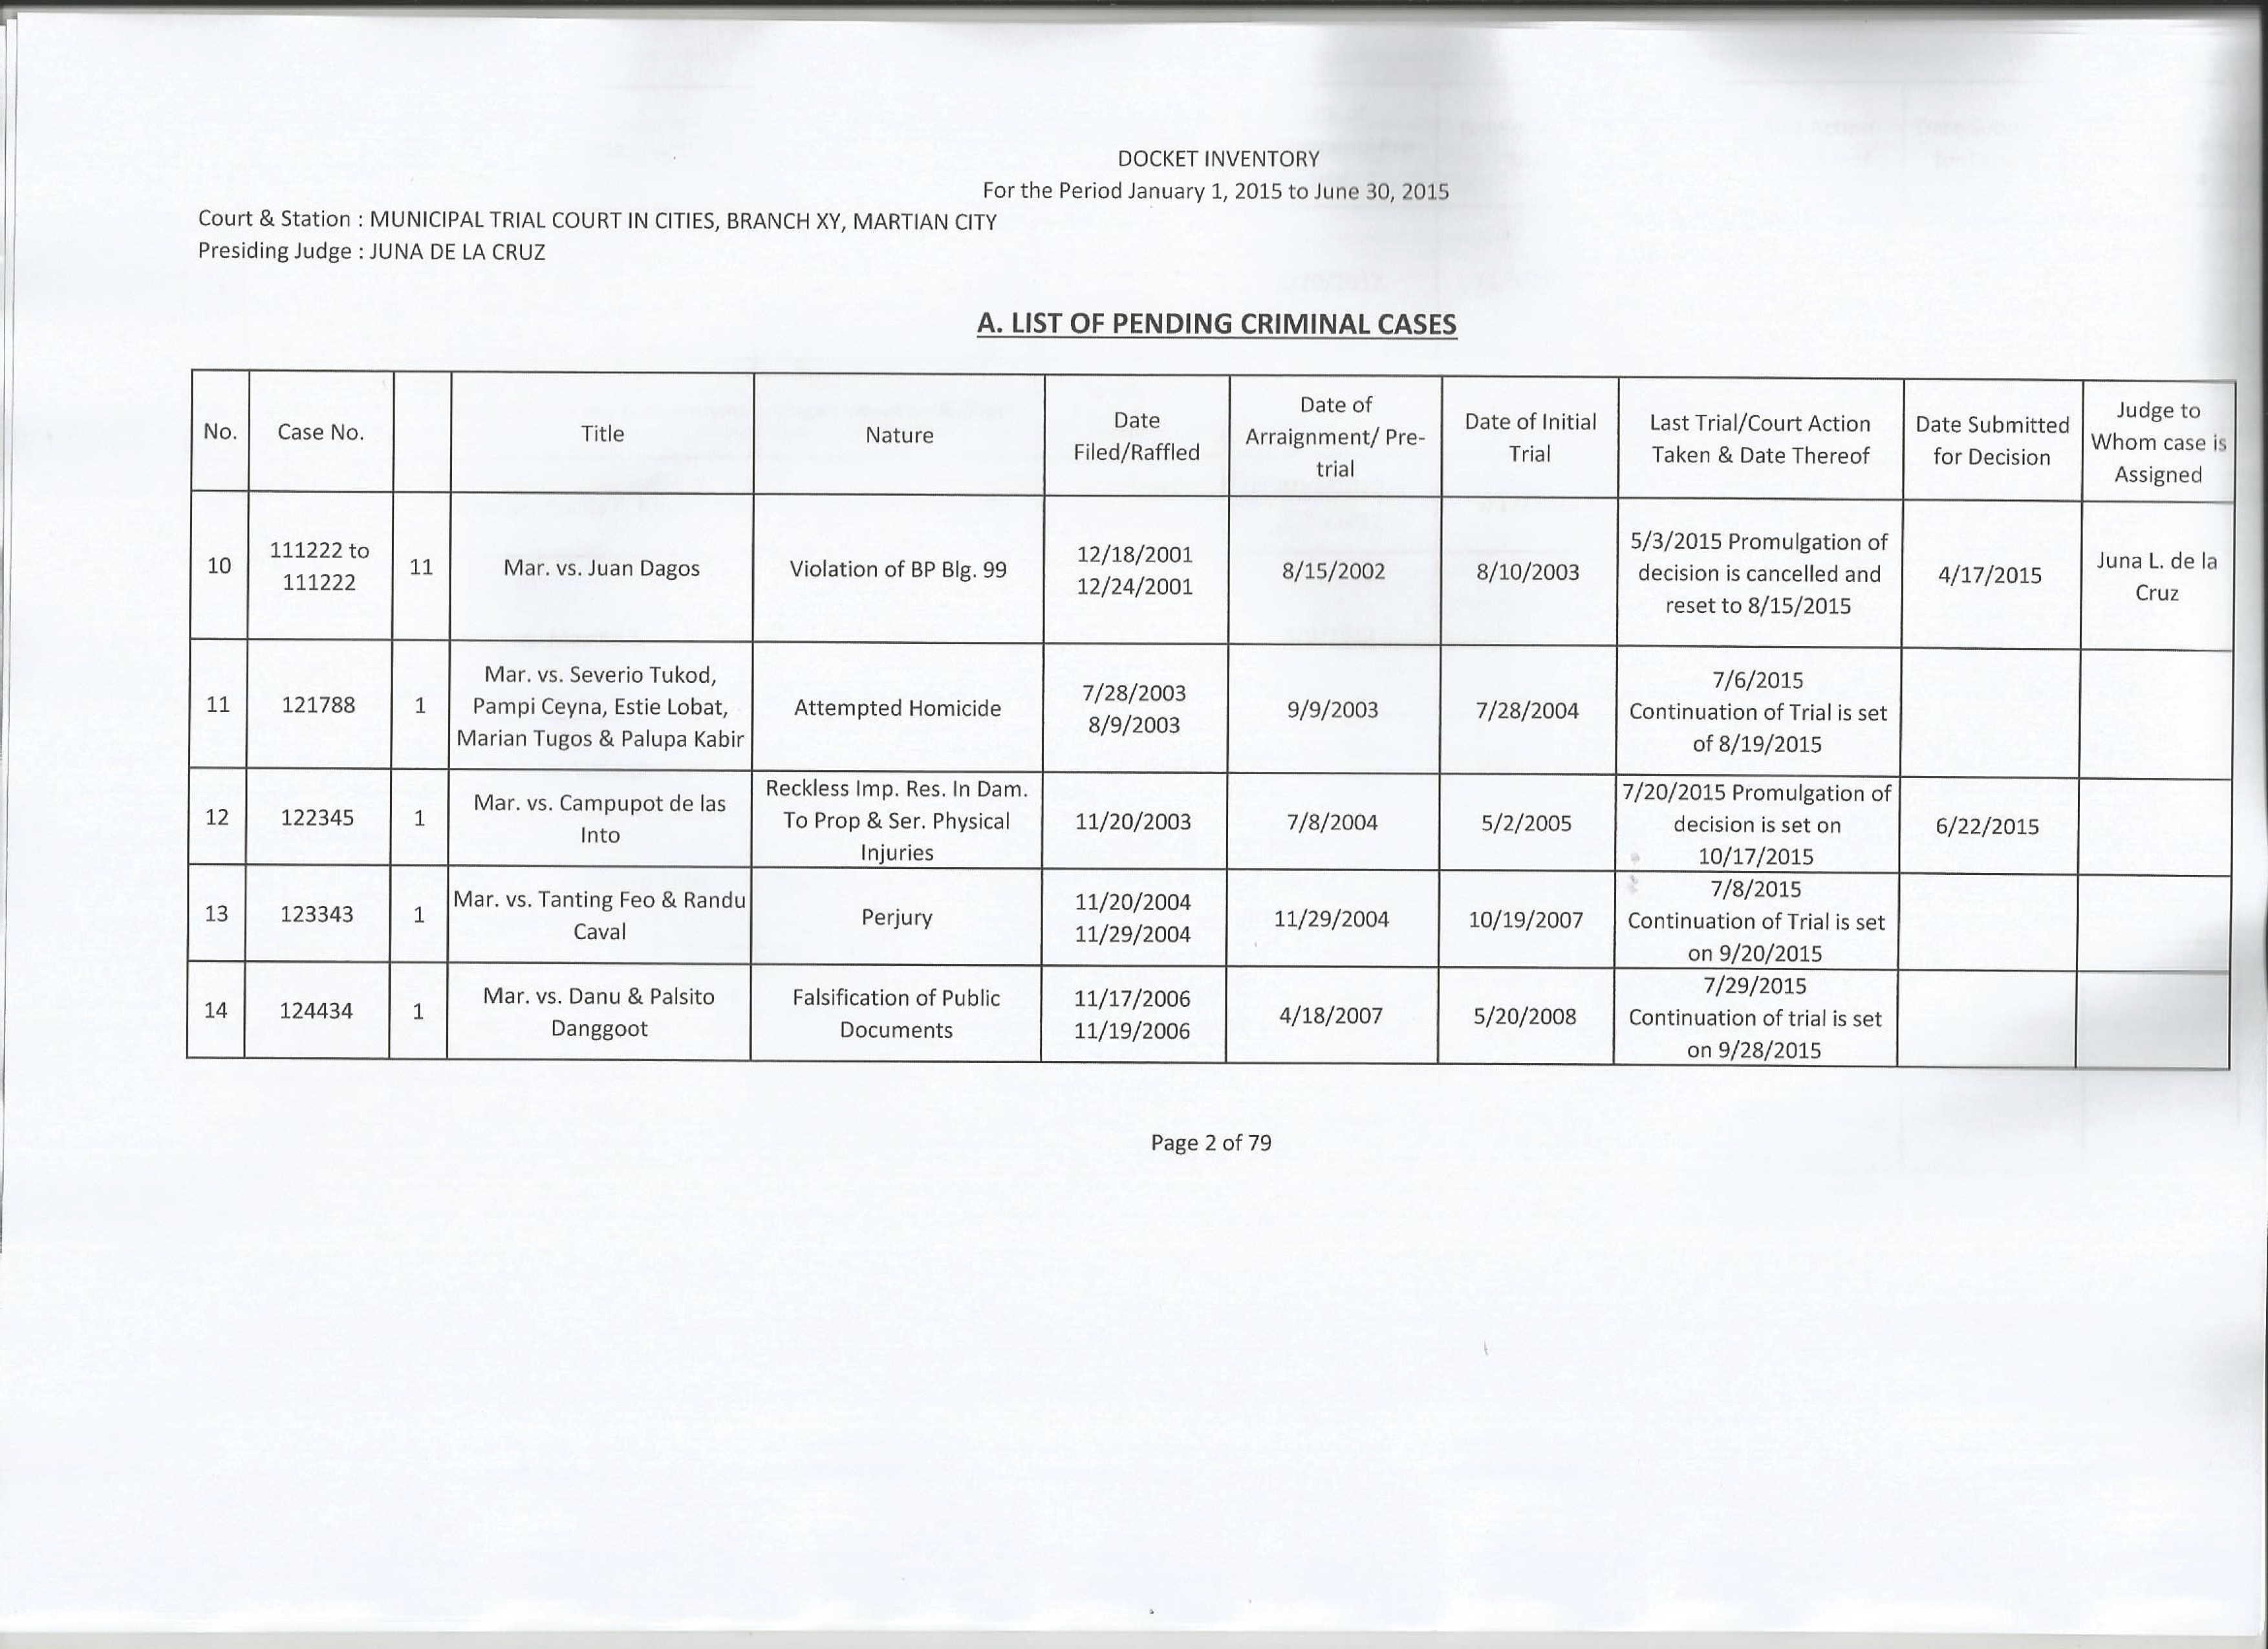

In [102]:
# For comparison 
display.Image(DATA_PATH + IMG_PATH)

In [103]:
# Save to csv
df.to_csv(OUTPUT_PATH + IMG_PATH.replace(".jpg", "") + "_parsed.csv", index=False)

## References

Code heavily drawn from:

- https://medium.com/coinmonks/a-box-detection-algorithm-for-any-image-containing-boxes-756c15d7ed26

- https://www.pyimagesearch.com/2017/07/10/using-tesseract-ocr-python/